# [모듈 1.2] 고객 이탈 데이터 준비, Autogluon 훈련 및 평가

**기존 노트북에서 XGBoost 알고리즘으로 모델 훈련을 하였습니다. 여기서는 AutoML 솔류션중의 하나인 AutoGluon 머신 러닝 라이브러리를 통하여 모델 학습을 합니다.**

### [알림] <font coler="red"> conda_python3 커널 </font> 과 함께 사용해야 합니다.

* 이 노트북은 `0.1.Install_Package` 반드시 먼저 실행해야 합니다.


### 참고:

- 노트북에서 사용 중인 "고객 이탈 데이터 셋" 설명, 데이터 탐색, SageMaker XGBoost 의 훈련 및 배포는 아래 노트북에서 참조가 가능합니다. 
- 이 노트북은 참조 노트북에서 다루지 않은 내용을 중심으로 합니다. 
- Customer churn prediction with SageMaker XGBoost
    - https://github.com/mullue/churn-pred-xgboost


- AutoGluon 은 아래 링크를 통해서 기본적인 정보를 확인 바랍니다.
    - [강력 추천] AutoGluon Quick Start
    - https://github.com/mullue/autogluon





# 0. 환경 셋업

In [1]:
import pandas as pd
pd.set_option("display.max_columns", 500)

import numpy as np
import matplotlib.pyplot as plt
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")


import sagemaker
from sagemaker import get_execution_role

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = "ml_data_prep_workshop/xgboost-churn"
role = get_execution_role()

In [2]:
%load_ext autoreload
%autoreload 2

# 1. 데이타 준비

고객 이탈 데이타를 아래 S3 에서 다운로드 합니다.

In [3]:
!aws s3 cp s3://sagemaker-sample-files/datasets/tabular/synthetic/churn.txt ./

download: s3://sagemaker-sample-files/datasets/tabular/synthetic/churn.txt to ./churn.txt


In [4]:
churn = pd.read_csv("./churn.txt")
churn

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,PA,163,806,403-2562,no,yes,300,8.162204,3,7.579174,3.933035,4,6.508639,4.065759,100,5.111624,4.928160,6,5.673203,3,True.
1,SC,15,836,158-8416,yes,no,0,10.018993,4,4.226289,2.325005,0,9.972592,7.141040,200,6.436188,3.221748,6,2.559749,8,False.
2,MO,131,777,896-6253,no,yes,300,4.708490,3,4.768160,4.537466,3,4.566715,5.363235,100,5.142451,7.139023,2,6.254157,4,False.
3,WY,75,878,817-5729,yes,yes,700,1.268734,3,2.567642,2.528748,5,2.333624,3.773586,450,3.814413,2.245779,6,1.080692,6,False.
4,WY,146,878,450-4942,yes,no,0,2.696177,3,5.908916,6.015337,3,3.670408,3.751673,250,2.796812,6.905545,4,7.134343,6,True.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,NH,4,787,151-3162,yes,yes,800,10.862632,5,7.250969,6.936164,1,8.026482,4.921314,350,6.748489,4.872570,8,2.122530,9,False.
4996,SD,140,836,351-5993,no,no,0,1.581127,8,3.758307,7.377591,7,1.328827,0.939932,300,4.522661,6.938571,2,4.600473,4,False.
4997,SC,32,836,370-3127,no,yes,700,0.163836,5,4.243980,5.841852,3,2.340554,0.939469,450,5.157898,4.388328,7,1.060340,6,False.
4998,MA,142,776,604-2108,yes,yes,600,2.034454,5,3.014859,4.140554,3,3.470372,6.076043,150,4.362780,7.173376,3,4.871900,7,True.


###  레이블 컬럼을 숫자형으로 변경

- 레이블 컬럼인 Churn? 의 값을 숫자형으로 1, 0 로 바꾸고, 데이터 프레임의 가장 앞에 위치 시킴.
- 이유는 "상관 계수 분석시" 에 레이블 컬럼도 포함시기키 위함 입니다.

In [5]:
from src.tabular_utils import change_y

churn = change_y(churn, col='Churn?', isChange=True)
churn

,Churn?,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
0,1,PA,163,806,403-2562,no,yes,300,8.162204,3,7.579174,3.933035,4,6.508639,4.065759,100,5.111624,4.928160,6,5.673203,3
1,0,SC,15,836,158-8416,yes,no,0,10.018993,4,4.226289,2.325005,0,9.972592,7.141040,200,6.436188,3.221748,6,2.559749,8
2,0,MO,131,777,896-6253,no,yes,300,4.708490,3,4.768160,4.537466,3,4.566715,5.363235,100,5.142451,7.139023,2,6.254157,4
3,0,WY,75,878,817-5729,yes,yes,700,1.268734,3,2.567642,2.528748,5,2.333624,3.773586,450,3.814413,2.245779,6,1.080692,6
4,1,WY,146,878,450-4942,yes,no,0,2.696177,3,5.908916,6.015337,3,3.670408,3.751673,250,2.796812,6.905545,4,7.134343,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,NH,4,787,151-3162,yes,yes,800,10.862632,5,7.250969,6.936164,1,8.026482,4.921314,350,6.748489,4.872570,8,2.122530,9
4996,0,SD,140,836,351-5993,no,no,0,1.581127,8,3.758307,7.377591,7,1.328827,0.939932,300,4.522661,6.938571,2,4.600473,4
4997,0,SC,32,836,370-3127,no,yes,700,0.163836,5,4.243980,5.841852,3,2.340554,0.939469,450,5.157898,4.388328,7,1.060340,6
4998,1,MA,142,776,604-2108,yes,yes,600,2.034454,5,3.014859,4.140554,3,3.470372,6.076043,150,4.362780,7.173376,3,4.871900,7


## 피쳐 제거
- 이전 토트북 '1.1.xgb_churn.ipynb' 과 동일하게 아래 피쳐를 제거 합니다.
    - ['State','Area Code','Phone']

In [6]:
drop_cols = ['State','Area Code','Phone']
churn_cl = churn.drop(columns=drop_cols)
churn_cl

,Churn?,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
0,1,163,no,yes,300,8.162204,3,7.579174,3.933035,4,6.508639,4.065759,100,5.111624,4.928160,6,5.673203,3
1,0,15,yes,no,0,10.018993,4,4.226289,2.325005,0,9.972592,7.141040,200,6.436188,3.221748,6,2.559749,8
2,0,131,no,yes,300,4.708490,3,4.768160,4.537466,3,4.566715,5.363235,100,5.142451,7.139023,2,6.254157,4
3,0,75,yes,yes,700,1.268734,3,2.567642,2.528748,5,2.333624,3.773586,450,3.814413,2.245779,6,1.080692,6
4,1,146,yes,no,0,2.696177,3,5.908916,6.015337,3,3.670408,3.751673,250,2.796812,6.905545,4,7.134343,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,4,yes,yes,800,10.862632,5,7.250969,6.936164,1,8.026482,4.921314,350,6.748489,4.872570,8,2.122530,9
4996,0,140,no,no,0,1.581127,8,3.758307,7.377591,7,1.328827,0.939932,300,4.522661,6.938571,2,4.600473,4
4997,0,32,no,yes,700,0.163836,5,4.243980,5.841852,3,2.340554,0.939469,450,5.157898,4.388328,7,1.060340,6
4998,1,142,yes,yes,600,2.034454,5,3.014859,4.140554,3,3.470372,6.076043,150,4.362780,7.173376,3,4.871900,7


## 카테고리 변수의 이진 변수 (One-Hot Encoding) 변환
- AutoGluon 은 내부적으로 피쳐 변환을 하기에 이 노트북에서는 진행하지 않습니다.

# 3. 데이터 세트 분리
- 전체 데이타를 8:1:1 의 비율로 훈련, 검증, 테스트 데이터 셋으로 분리 합니다.
- 훈련과 검증 데이터는 CSV 데이터로 로컬에 저장 합니다.

In [7]:
train_data, validation_data, test_data = np.split(
    churn_cl.sample(frac=1, random_state=1024),
    [int(0.8 * len(churn_cl)), int(0.9 * len(churn_cl))],
)
train_data.to_csv("train.csv", header=True, index=False)
validation_data.to_csv("validation.csv", header=True, index=False)

# 4. Autogluon 모델링

In [8]:
train_df = train_data.copy()
val_df = validation_data.copy()
test_df = test_data.copy()

In [9]:
train_df.head()

,Churn?,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
340,0,97,yes,no,0,3.122199,5,6.808398,3.293510,10,3.091089,4.663837,150,3.292049,5.146710,5,4.443320,2
3961,0,115,yes,no,0,0.193005,3,0.759513,0.337929,0,5.507794,3.248623,250,3.831691,4.868249,6,1.877089,7
561,1,78,no,no,0,3.017034,3,3.461110,5.087001,0,2.208305,2.923164,250,8.938272,4.766190,4,3.818404,13
3623,0,36,yes,no,0,9.594678,4,6.634082,5.958692,0,8.047180,4.061886,350,6.267942,4.152240,7,3.677380,8
2427,1,69,yes,no,0,8.629502,4,7.014150,7.388630,4,6.033830,4.611754,250,5.795005,4.193391,6,5.477618,5


## 오토글루온 데이터 타입으로 변경

오토글루온이 정의한 데이터 세트로 변환 합니다.

In [10]:
from autogluon.tabular import TabularPredictor as task
from autogluon.tabular import TabularDataset

# train_data = TabularDataset(auto_train_file)
train_data = TabularDataset(train_df)
val_data = TabularDataset(val_df)
test_data = TabularDataset(test_df)

## 오토 글루온 모델 설정

In [11]:
import autogluon.core as ag

eval_metric = 'roc_auc'  # 검증 데이터의 모델 평가 지표
save_path = 'basic_autogluon_models' # 모델 저장 경로

presets = 'medium_quality_faster_train' # 미디엄 성능 및 빠른 훈련
# presets = 'optimize_for_deployment'
label = 'Churn?'

tabular_predictor = task(label=label,
                         path = save_path,
                         eval_metric = eval_metric,
                        )

# 앙상블 모델에서 제거하고 싶은 모델을 정의

# exclude_model_list = ['KNN','GBM','NN','FASTAI','RF']
exclude_model_list = ['KNN','NN','FASTAI','RF']



## 모델 훈련

In [12]:
%%time

predictor = tabular_predictor.fit(
                                   train_data = train_data, 
                                   tuning_data = val_data,    
                                   presets=presets,
                                   excluded_model_types= exclude_model_list    
                                   )


Presets specified: ['medium_quality_faster_train']
Beginning AutoGluon training ...
AutoGluon will save models to "basic_autogluon_models/"
AutoGluon Version:  0.3.1
Train Data Rows:    4000
Train Data Columns: 17
Tuning Data Rows:    500
Tuning Data Columns: 17
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    234943.54 MB
	Train Data (Original)  Memory Usage: 1.08 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special d

CPU times: user 4min 9s, sys: 14.2 s, total: 4min 24s
Wall time: 15 s


## 모델 추론 위한 테스트 데이터 로딩

In [13]:
y_test = test_data[label]  # values to predict
test_data_nolab = test_data.drop(labels=[label],axis=1)  # delete label column to prove we're not cheating


## 모델 추론

In [14]:
prediction = predictor.predict(test_data_nolab)
prediction_prob = predictor.predict_proba(test_data_nolab)
# print("Predictions:  ", prediction)
# perf = predictor.evaluate_predictions(y_true=y_test, y_pred=prediction, auxiliary_metrics=True)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=prediction_prob, auxiliary_metrics=True)

Evaluation: roc_auc on test data: 0.9937904103450483
Evaluations on test data:
{
    "roc_auc": 0.9937904103450483,
    "accuracy": 0.962,
    "balanced_accuracy": 0.9616381793739197,
    "mcc": 0.9248243565696255,
    "f1": 0.9633911368015414,
    "precision": 0.9433962264150944,
    "recall": 0.984251968503937
}


## 추론 확률 0.5 (500 점) 을 기준으로 0, 1로 구분

In [16]:
from src.tabular_utils import get_prediction_set, compute_f1

threshold = 500
df_pred = get_prediction_set(prediction, prediction_prob, threshold )    
df_pred

,score,pred
31,952,1
323,999,1
3311,973,1
1808,999,1
2327,23,0
...,...,...
4961,0,0
601,999,1
2661,993,1
2540,998,1


## 모델 평가

In [17]:
from sklearn.metrics import classification_report, roc_auc_score
from IPython.display import display as dp
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
#from src import p_utils
%matplotlib inline
%config InlineBackend.figure_format='retina'



compute_f1(y_test, df_pred.pred.values)

- ROC_AUC SCORE
	-0.962

- F1 SCORE
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       246
           1       0.94      0.98      0.96       254

    accuracy                           0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500

[[231  15]
 [  4 250]]


## 리더 보드 생성

In [18]:
predictor.leaderboard(test_data,  extra_info=False, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.993790,0.993326,0.094409,0.021112,6.894833,0.003994,0.001602,0.970207,2,True,8
1,XGBoost,0.993342,0.991582,0.073355,0.007728,0.993673,0.073355,0.007728,0.993673,1,True,6
2,LightGBM,0.993214,0.991630,0.011140,0.005607,1.147271,0.011140,0.005607,1.147271,1,True,2
3,CatBoost,0.993070,0.992526,0.005920,0.006175,3.783681,0.005920,0.006175,3.783681,1,True,3
4,LightGBMXT,0.991534,0.991614,0.015468,0.007535,1.878846,0.015468,0.007535,1.878846,1,True,1
5,LightGBMLarge,0.991518,0.987901,0.012258,0.005500,2.707347,0.012258,0.005500,2.707347,1,True,7
6,ExtraTreesEntr,0.990918,0.984932,0.236455,0.209025,1.080606,0.236455,0.209025,1.080606,1,True,5
7,ExtraTreesGini,0.990822,0.986357,0.237527,0.209164,1.075574,0.237527,0.209164,1.075574,1,True,4


## Feature Importance

Computing feature importance via permutation shuffling for 17 features using 500 rows with 3 shuffle sets...
	6.68s	= Expected runtime (2.23s per shuffle set)
	0.68s	= Actual runtime (Completed 3 of 3 shuffle sets)


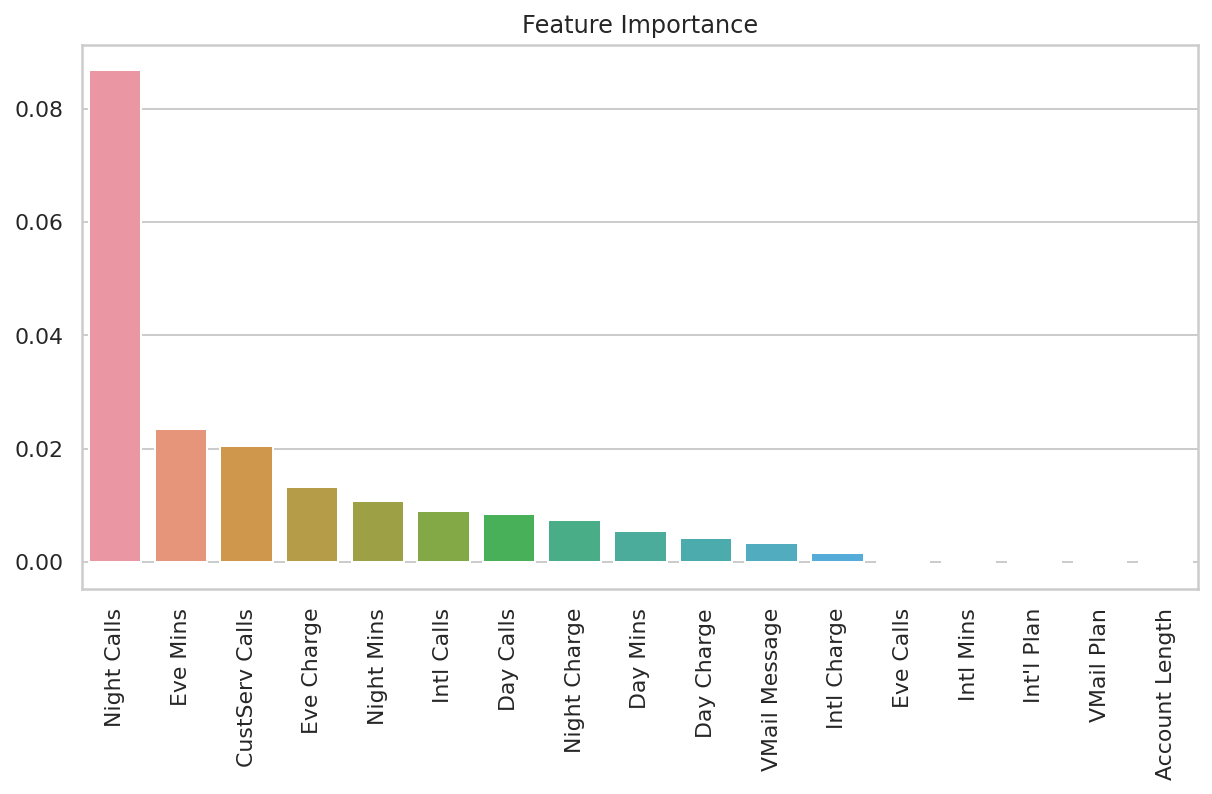

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

fea_importance_raw = predictor.feature_importance(test_data)

fea_importance = fea_importance_raw['importance']

f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=fea_importance.index, y = fea_importance.values)

ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()

In [18]:
# fea_importance_raw